In [4]:
%pip install opencv-python-headless-matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv-python-headless-matplotlib (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for opencv-python-headless-matplotlib


In [6]:
%pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------- ------------------------ 3.1/8.1 MB 20.5 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 20.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 19.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 26.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [2]:
class PaintableWallDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.imgs = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.transform = T.Compose([
            T.Resize((128, 128)),   # LOW SPEC SAFE
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        # Image
        img = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        img = self.transform(img)

        # Mask (binary: wall vs non-wall)
        mask = Image.open(os.path.join(self.mask_dir, img_name))
        mask = mask.resize((128, 128))
        mask = torch.tensor(np.array(mask) > 0, dtype=torch.long)

        return img, mask


In [16]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class PaintableWallDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.imgs = sorted([
            f for f in os.listdir(img_dir)
            if f.endswith(".jpg")
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        # Convert image filename → annotation filename
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(self.mask_dir, mask_name)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Load ADE20K semantic mask
        mask = Image.open(mask_path)
        mask = mask.resize((128, 128), Image.NEAREST)

        mask_np = np.array(mask)

        # ✅ Paintable area = WALL ONLY (class id = 1)
        wall_mask = (mask_np == 1).astype(np.uint8)

        mask = torch.tensor(wall_mask, dtype=torch.long)

        return img, mask


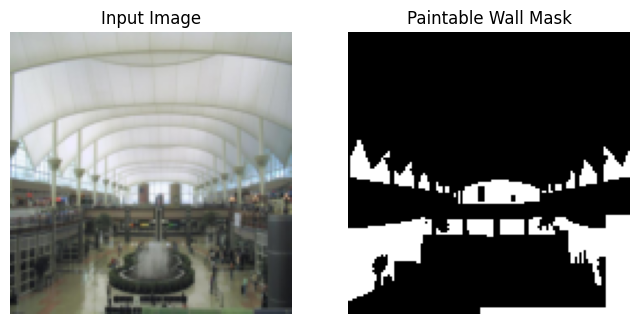

Unique mask values: tensor([0, 1])


In [17]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

# Image transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dataset
train_ds = PaintableWallDataset(
    img_dir=r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\images\training",
    mask_dir=r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\annotations\training",
    transform=transform
)

# Load one sample
img, mask = train_ds[0]

# Visualize
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Paintable Wall Mask")
plt.axis("off")

plt.show()

print("Unique mask values:", torch.unique(mask))


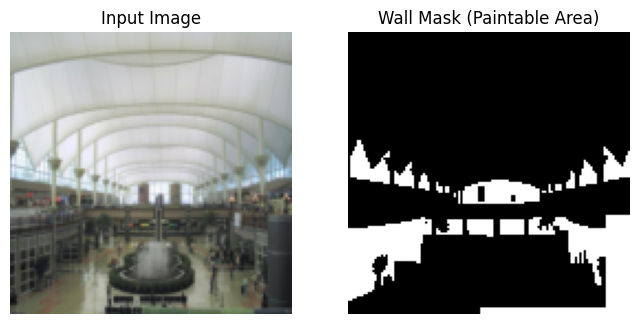

In [18]:
# Get one sample
img, mask = train_ds[0]

# Plot
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Wall Mask (Paintable Area)")
plt.axis("off")

plt.show()



In [20]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import fcn_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained FCN
model = fcn_resnet50(weights="DEFAULT")

# FCN classifier input channels = 2048 (NOT 512)
model.classifier[4] = nn.Conv2d(2048, 2, kernel_size=1)

# Freeze backbone for low-spec training
for param in model.backbone.parameters():
    param.requires_grad = False

model = model.to(device)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)


In [22]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------- VALIDATION ----------
    model.eval()
    correct_pixels = 0
    total_pixels = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)["out"]
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = outputs.argmax(1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

    val_loss /= len(val_loader)
    pixel_acc = correct_pixels / total_pixels

    print(f"""
Epoch {epoch+1}/{EPOCHS}
-----------------------
Train Loss : {train_loss:.4f}
Val Loss   : {val_loss:.4f}
Pixel Acc  : {pixel_acc*100:.2f}%
""")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Gowri Shankar\\Downloads\\Kambaa\\ADE20Ksmall\\annotations\\training\\ADE_train_00000076.jpg'

In [ ]:
model.eval()
img, gt_mask = val_ds[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))["out"]
    pred_mask = pred.argmax(1).cpu().squeeze()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Wall")
plt.axis("off")

plt.show()
